## Alert histograms

### Imports

In [1]:
from astropy.time import Time
import datetime
import humanize
from IPython.core.display import display, HTML
import json
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from multiprocessing.pool import ThreadPool
import pandas as pd
from pandas.plotting import register_matplotlib_converters
from penquins import Kowalski
from tqdm.auto import tqdm

# plt.style.use(['dark_background'])
register_matplotlib_converters()
%matplotlib inline

In [2]:
with open('secrets_penquins.json', 'r') as f:
    secrets = json.load(f)

In [3]:
k = Kowalski(username=secrets['kowalski']['username'],
             password=secrets['kowalski']['password'])

In [4]:
q = {"query_type": "general_search",
     "query": "db['ZTF_alerts'].estimated_document_count()"}
r = k.query(query=q)
total = r['result_data']['query_result']
print(f'Total alerts as of {datetime.datetime.utcnow()}: {humanize.intcomma(total)}')

Total alerts as of 2020-01-27 22:56:42.901988: 232,353,175


In [5]:
d0 = datetime.datetime(2018, 2, 9)
# d0 = datetime.datetime(2019, 6, 29)
# d0 = datetime.datetime(2018, 9, 1)
now = datetime.datetime.utcnow()
dd = (now - d0).days
dates = [{'utc_date': (d0 + datetime.timedelta(days=ddd)),
          'utc_date_str': (d0 + datetime.timedelta(days=ddd)).strftime('%Y%m%d'),
          'jd': Time(d0 + datetime.timedelta(days=ddd)).jd,
          'total': 0,
          'programid_0': 0,
          'programid_1': 0,
          'programid_2': 0,
          'programid_3': 0} for ddd in range(dd)]

In [6]:
# for date in tqdm(dates):
#     # total:
#     qq = {"query_type": "general_search",
#           "query": f"db['ZTF_alerts'].count_documents({{'candidate.jd': {{'$gt': {date['jd']},"
#                     f" '$lt': {date['jd'] + 1}}}}})"}
#     rr = k.query(query=qq)
#     total_date = rr['result_data']['query_result']
#     date['total'] = total_date
#     # per programid:
#     for programid in range(4):
#         qq = {"query_type": "general_search",
#               "query": f"db['ZTF_alerts'].count_documents({{'candidate.jd': {{'$gt': {date['jd']},"
#                         f" '$lt': {date['jd'] + 1}}}, 'candidate.programid': {programid}}})"}
#         rr = k.query(query=qq)
#         pid_date = rr['result_data']['query_result']
#         date[f'programid_{programid}'] = pid_date

In [9]:
def date_stats(date):
    # total:
    qq = {"query_type": "count_documents",
          "query": {
              "catalog": "ZTF_alerts",
              "filter": {
                  'candidate.jd': {'$gt': date['jd'], '$lt': date['jd'] + 1}
              }
          },
          "kwargs": {
             "hint": "candidate.jd_1_candidate.programid_1_candidate.programpi_1",
             "max_time_ms": 10000
         }
         }
    rr = k.query(query=qq)
    total_date = rr.get('result_data', dict()).get('query_result')
    date['total'] = total_date
    # per programid:
    for programid in range(4):
        qq = {"query_type": "count_documents",
              "query": {
                  "catalog": "ZTF_alerts",
                  "filter": {
                      'candidate.jd': {'$gt': date['jd'], '$lt': date['jd'] + 1},
                      'candidate.programid': programid
                  }
              },
              "kwargs": {
                 "hint": "candidate.jd_1_candidate.programid_1_candidate.programpi_1",
                 "max_time_ms": 10000
             }
             }
        rr = k.query(query=qq)
        pid_date = rr.get('result_data', dict()).get('query_result')
        date[f'programid_{programid}'] = pid_date
    
    return date

In [10]:
with ThreadPool(processes=10) as pool:
    dates = list(tqdm(pool.imap(date_stats, dates), total=len(dates)))

In [11]:
df = pd.DataFrame.from_records(dates)
df.sort_values(by='jd')
df.to_csv(f'alert_stats_{datetime.datetime.now().strftime("%Y%m%d_%H%M%S")}.csv')

pd.set_option('display.max_rows', None)
df

,jd,programid_0,programid_1,programid_2,programid_3,total,utc_date,utc_date_str
0,2458158.5,201691,0,0,0,201691,2018-02-09,20180209
1,2458159.5,9134,0,0,0,9134,2018-02-10,20180210
2,2458160.5,107244,0,0,0,107244,2018-02-11,20180211
3,2458161.5,0,0,0,0,0,2018-02-12,20180212
4,2458162.5,0,0,0,0,0,2018-02-13,20180213
5,2458163.5,0,0,0,0,0,2018-02-14,20180214
6,2458164.5,0,0,0,0,0,2018-02-15,20180215
7,2458165.5,17843,0,0,685,18528,2018-02-16,20180216
8,2458166.5,0,0,0,0,0,2018-02-17,20180217
9,2458167.5,10,0,0,0,10,2018-02-18,20180218


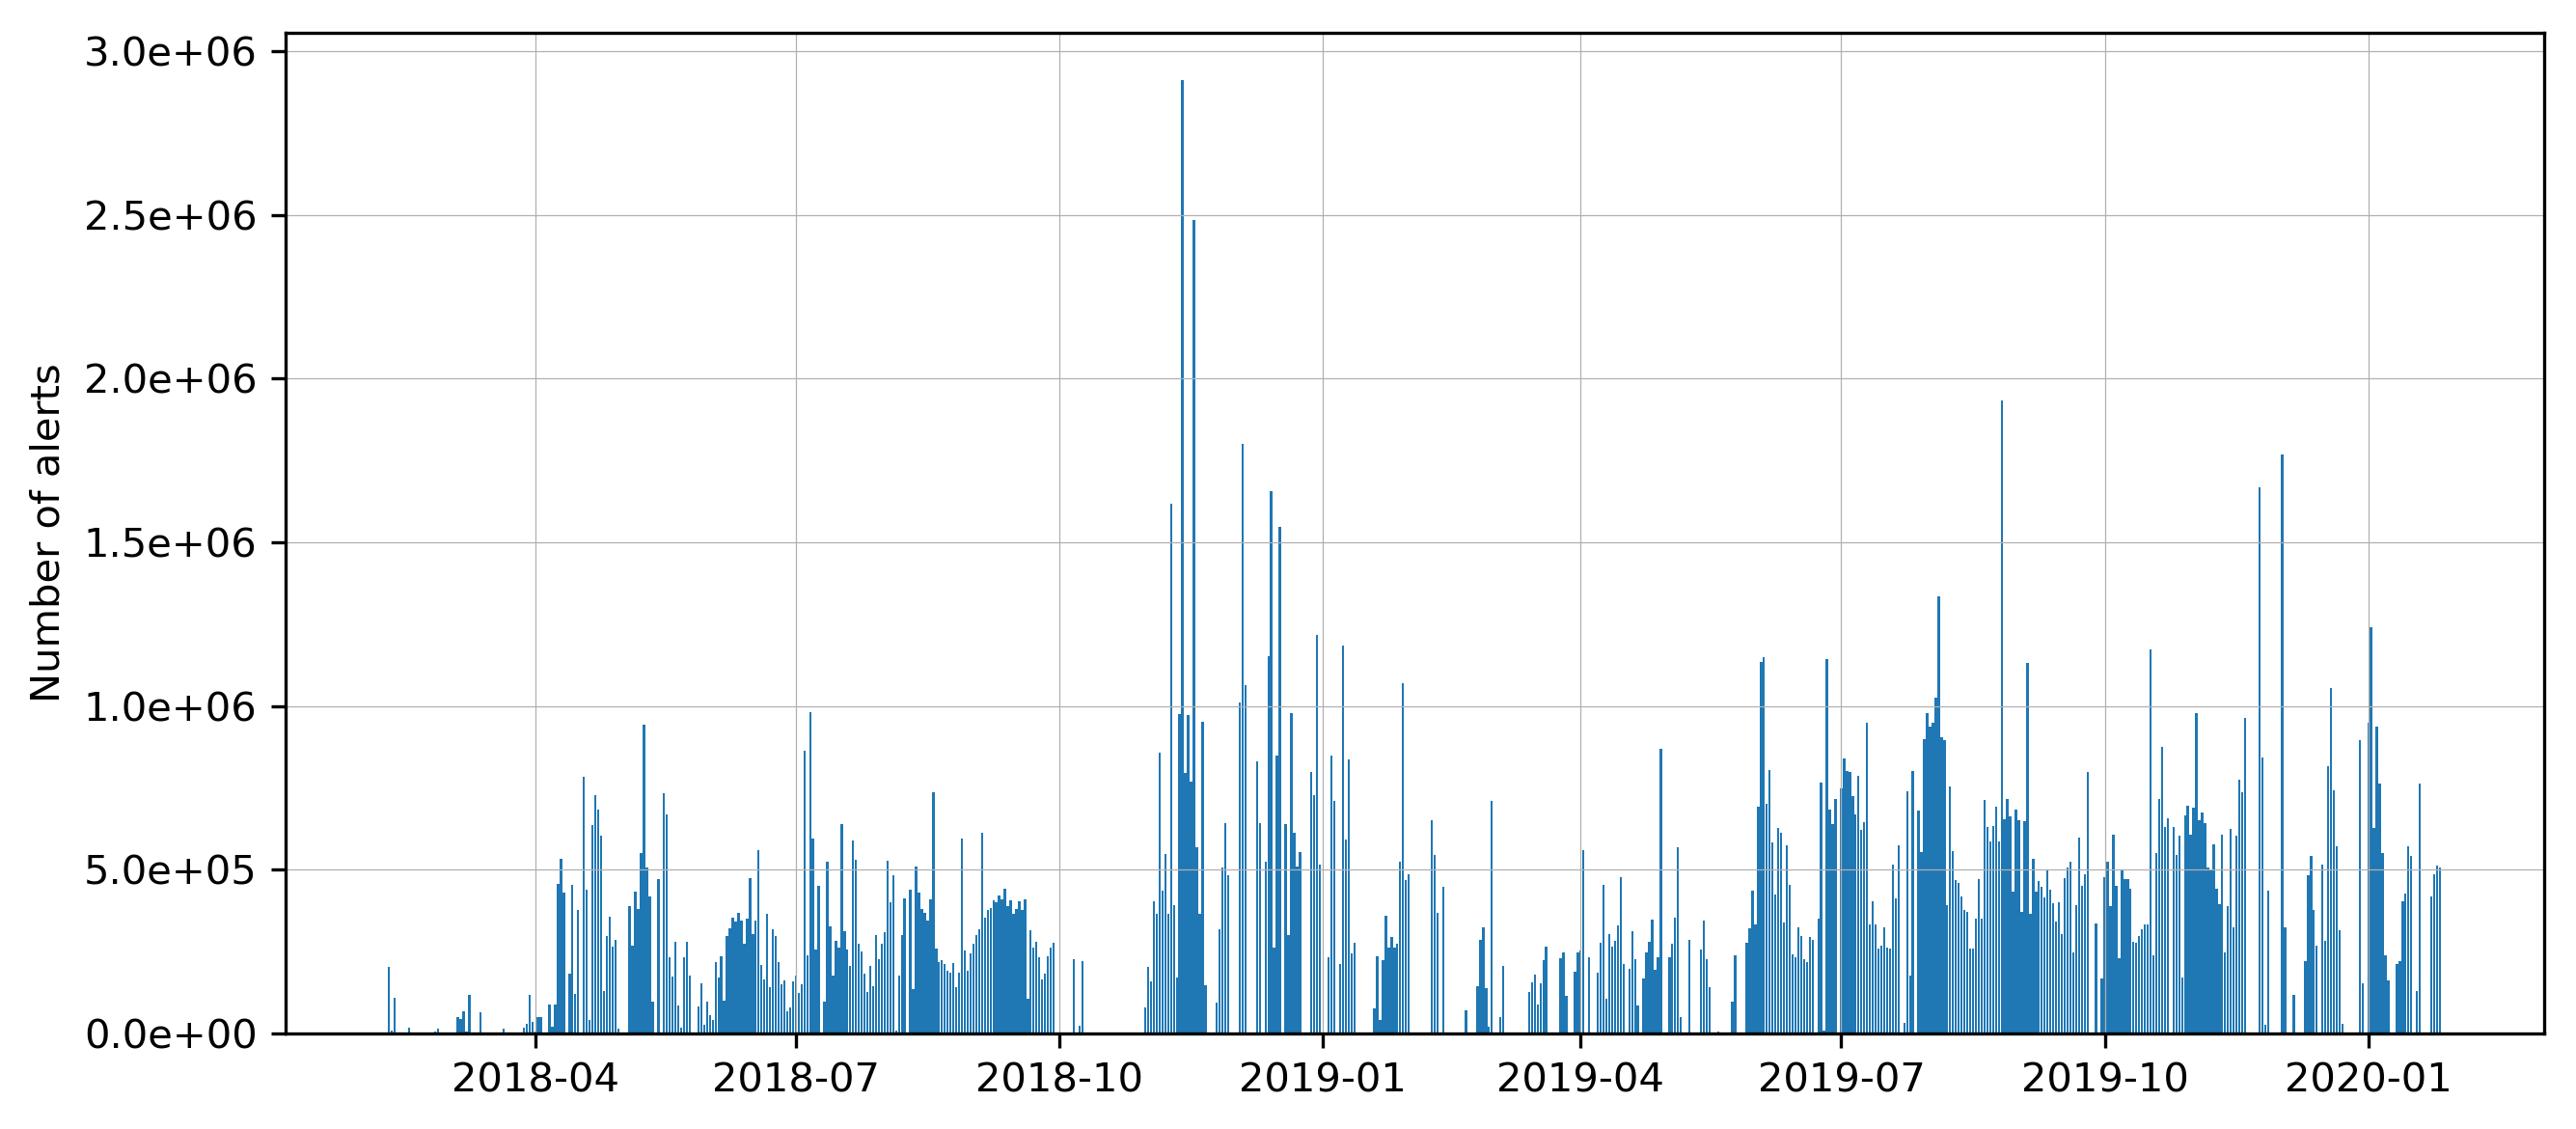

In [12]:
fig = plt.figure(figsize=(9, 4), dpi=300)
ax = fig.add_subplot(111)
ax.bar(df.utc_date, df.total)
ax.set_ylabel('Number of alerts')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1e'))
# ax.legend(loc='best')
ax.grid(True, linewidth=.3)
plt.tight_layout()

In [13]:
print(f"Total alerts from {d0.strftime('%Y-%m-%d')} to {now.strftime('%Y-%m-%d')}:", 
      humanize.intcomma(df['total'].sum()))
for pid in range(4):
    print(f"\tprogramid {pid}:", humanize.intcomma(df[f'programid_{pid}'].sum()))

Total alerts from 2018-02-09 to 2020-01-27: 231,868,281
	programid 0: 1,599,566
	programid 1: 80,449,339
	programid 2: 103,408,786
	programid 3: 46,410,590
